In [1]:
import os
import io
import trimesh
import b3d
import genjax
import jax
import b3d.bayes3d as bayes3d
import jax.numpy as jnp
import numpy as np
import rerun as rr
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import json
import b3d.utils as utils
import random
from copy import deepcopy
import itertools
import pycocotools.mask as mask_util
from scipy.spatial.transform import Rotation
from tqdm import tqdm
from functools import reduce
from genjax import Pytree
from physion_utils import *
import b3d.chisight.dense.dense_model
import b3d.chisight.dense.likelihoods.laplace_likelihood
import collections
from genjax._src.core.serialization.msgpack import msgpack_serialize

In [2]:
rr.init("demo")
rr.connect("127.0.0.1:8812")
rr.log("/", rr.ViewCoordinates.LEFT_HAND_Y_UP, static=True)  # Set an up-axis

## define helper functions

In [3]:
def scale_mesh(vertices, scale_factor):
    vertices_copy = deepcopy(vertices)
    vertices_copy[:, 0] *= scale_factor[0]
    vertices_copy[:, 1] *= scale_factor[1]
    vertices_copy[:, 2] *= scale_factor[2]
    return vertices_copy

def euler_angles_to_quaternion(euler: np.ndarray) -> np.ndarray:
    """
    Convert Euler angles to a quaternion.

    Source: https://pastebin.com/riRLRvch

    :param euler: The Euler angles vector.

    :return: The quaternion representation of the Euler angles.
    """
    pitch = np.radians(euler[0] * 0.5)
    cp = np.cos(pitch)
    sp = np.sin(pitch)

    yaw = np.radians(euler[1] * 0.5)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    roll = np.radians(euler[2] * 0.5)
    cr = np.cos(roll)
    sr = np.sin(roll)

    x = sy * cp * sr + cy * sp * cr
    y = sy * cp * cr - cy * sp * sr
    z = cy * cp * sr - sy * sp * cr
    w = cy * cp * cr + sy * sp * sr
    return np.array([x, y, z, w])

def get_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img == color
        arr = arr.min(-1).astype('float32')
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)

def get_compli_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img != color
        arr = arr.min(-1).astype('float32')
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)

def unproject_pixels(mask, depth_map, cam_matrix, fx, fy):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''
    depth = depth_map[mask]
    pts = np.array([[x,y] for x,y in zip(np.nonzero(mask)[0], np.nonzero(mask)[1])])
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth_map.shape[0]
    width = depth_map.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    
    return points_in_world

def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def blackout_image(depth_map, area):
    # zero_depth_map = np.ones(depth_map.shape) * (-np.inf)
    zero_depth_map = np.zeros(depth_map.shape)
    zero_depth_map[area] = depth_map[area]
    return zero_depth_map


## load basic information from hdf5

In [4]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

resnet_inference_path = os.path.join(
    b3d.get_root_path(),
    "resnet_results/",)

stim_name = 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0013'

hdf5_file_path = os.path.join(physion_assets_path,
    f"{stim_name}.hdf5",
)

mesh_file_path = os.path.join(physion_assets_path,
    f"all_flex_meshes/core",
)

json_file_path = os.path.join(resnet_inference_path,
    f"{stim_name}.json",
)

im_width = 100
im_height = 100

In [5]:
vfov = 54.43222 
near_plane = 0.1
far_plane = 100
depth_arr = []
image_arr = []
base_id, base_type, attachment_id, attachent_type, attachment_fixed, use_attachment, use_base, use_cap = None, None, None, None, None, None, None, None
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    for key in f['frames'].keys():
        depth = jnp.array(f['frames'][key]['images']['_depth_cam0'])
        depth_arr.append(depth)
        image = jnp.array(Image.open(io.BytesIO(f['frames'][key]['images']['_img_cam0'][:])))
        image_arr.append(image)
    depth_arr = jnp.asarray(depth_arr)
    image_arr = jnp.asarray(image_arr)/255
    FINAL_T, height, width = image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]
    # FINAL_T = image_arr.shape[0]

    # extract camera info
    camera_azimuth = np.array(f['azimuth']['cam_0'])
    camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))
    projection_matrix = np.array(f['frames']['0000']['camera_matrices']['projection_matrix_cam0']).reshape((4, 4))
    im_seg = jnp.array(Image.open(io.BytesIO(f['frames']['0000']['images']['_id_cam0'][:])))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov

    # extract object info
    object_ids = np.array(f['static']['object_ids'])
    model_names = np.array(f['static']['model_names'])
    assert len(object_ids) == len(model_names)

    distractors = np.array(f['static']['distractors']) if np.array(f['static']['distractors']).size != 0 else None
    occluders = np.array(f['static']['occluders']) if np.array(f['static']['occluders']).size != 0 else None
    distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
    occluder_ids = np.concatenate([np.where(model_names==occluder)[0] for occluder in occluders], axis=0).tolist() if occluders else []
    excluded_model_ids = distractor_ids+occluder_ids
    included_model_ids = [idx for idx in range(len(object_ids)) if idx not in excluded_model_ids]
    object_ids = included_model_ids
    
    object_segmentation_colors = np.array(f['static']['object_segmentation_colors'])
    initial_position = np.array(f['static']['initial_position'])
    initial_rotation = np.array(f['static']['initial_rotation'])
    scales = np.array(f['static']['scale'])
    if "base_id" in np.array(f['static']) and "attachment_id" in np.array(f['static']):
        base_id = np.array(f['static']['base_id'])
        base_type = np.array(f['static']['base_type'])
        attachment_id = np.array(f['static']['attachment_id'])
        attachent_type = np.array(f['static']['attachent_type'])
        attachment_fixed = np.array(f['static']['attachment_fixed'])
        use_attachment = np.array(f['static']['use_attachment'])
        use_base = np.array(f['static']['use_base'])
        use_cap = np.array(f['static']['use_cap'])
        assert attachment_id.size==1
        assert base_id.size==1
        attachment_id = attachment_id.item()
        base_id = base_id.item()
        print(base_id, base_type, attachment_id, attachent_type, attachment_fixed, use_attachment, use_base, use_cap)

4 b'cylinder' 5 b'cylinder' True True True False


## b3d modeling

In [6]:
all_meshes = {}
for path, dirs, files in os.walk(mesh_file_path):
    for name in (files + dirs):
        if name.endswith('.obj'):
            mesh = trimesh.load(os.path.join(path, name))
            all_meshes[name[:-4]] = mesh
ordered_all_meshes = collections.OrderedDict(sorted(all_meshes.items()))

In [7]:
len(ordered_all_meshes)

17

In [8]:
R = camera_matrix[:3,:3]
T = camera_matrix[0:3, 3]
a = np.array([-R[0,:], -R[1,:], -R[2,:]])
b = np.array(T)
camera_position_from_matrix = np.linalg.solve(a, b)
camera_rotation_from_matrix = -np.transpose(R)
camera_pose = b3d.Pose(
    camera_position_from_matrix,
    b3d.Rot.from_matrix(camera_rotation_from_matrix).as_quat()
)

In [9]:
# Defines the enumeration schedule.
scaling_factor = im_width/width
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor,
    height * scaling_factor,
    fx * scaling_factor,
    fy * scaling_factor,
    (width/2) * scaling_factor,
    (height/2) * scaling_factor,
    near_plane,
    far_plane,
)

b3d.reload(b3d.chisight.dense.dense_model)
b3d.reload(b3d.chisight.dense.likelihoods.laplace_likelihood)
likelihood_func = b3d.chisight.dense.likelihoods.laplace_likelihood.likelihood_func
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, likelihood_func
    )
)
importance_jit = jax.jit(model.importance)

likelihood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "image_width": Pytree.const(renderer.width),
    "image_height": Pytree.const(renderer.height),
}


/home/haoliangwang/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [10]:
rgbds = jnp.concatenate([image_arr, jnp.reshape(depth_arr, depth_arr.shape+(1,))], axis=-1)

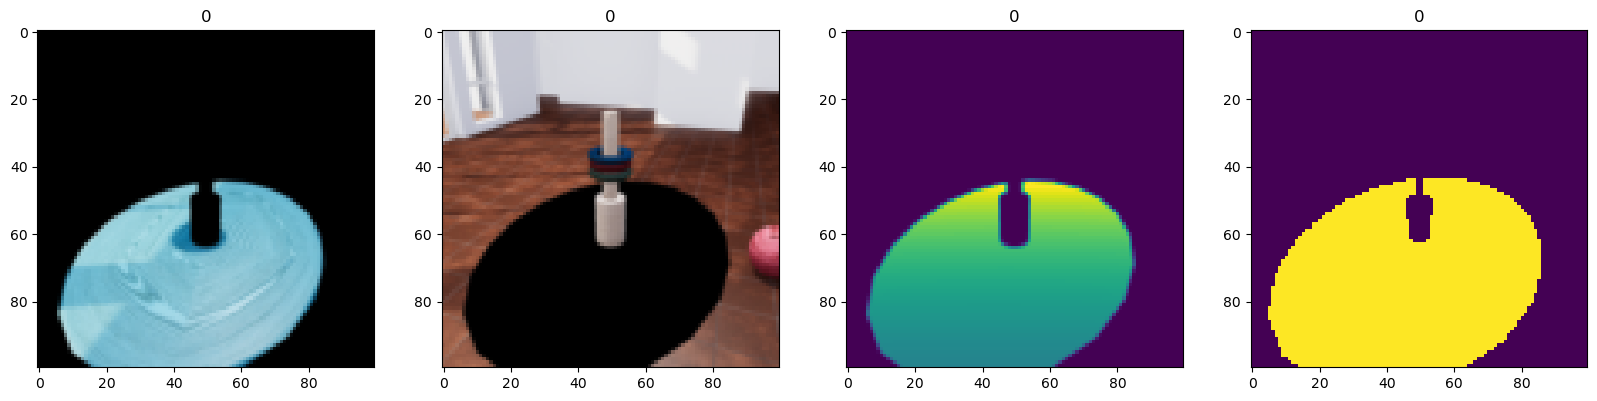

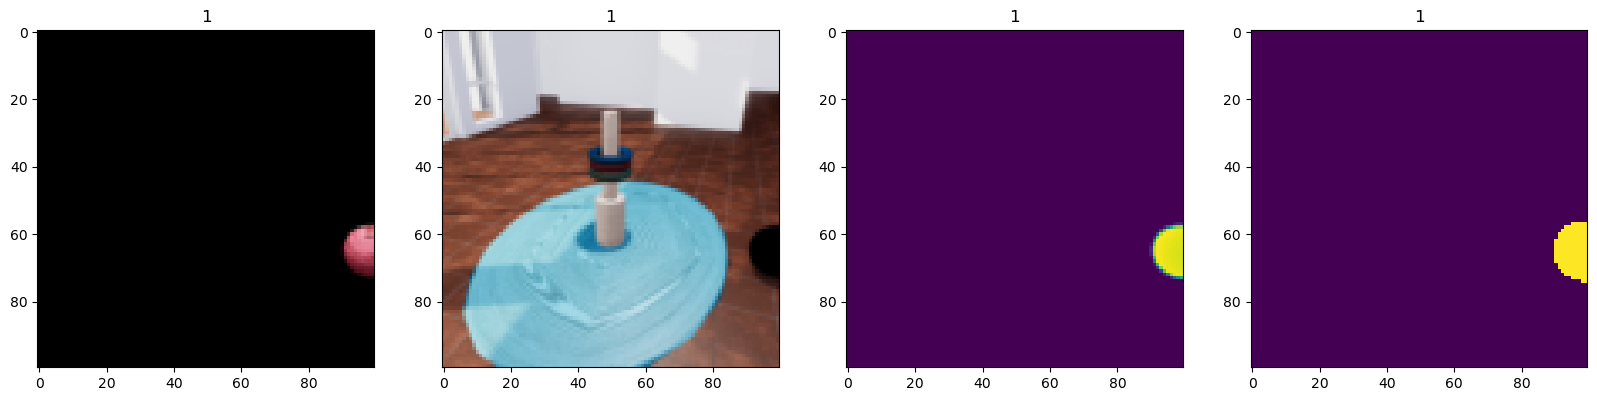

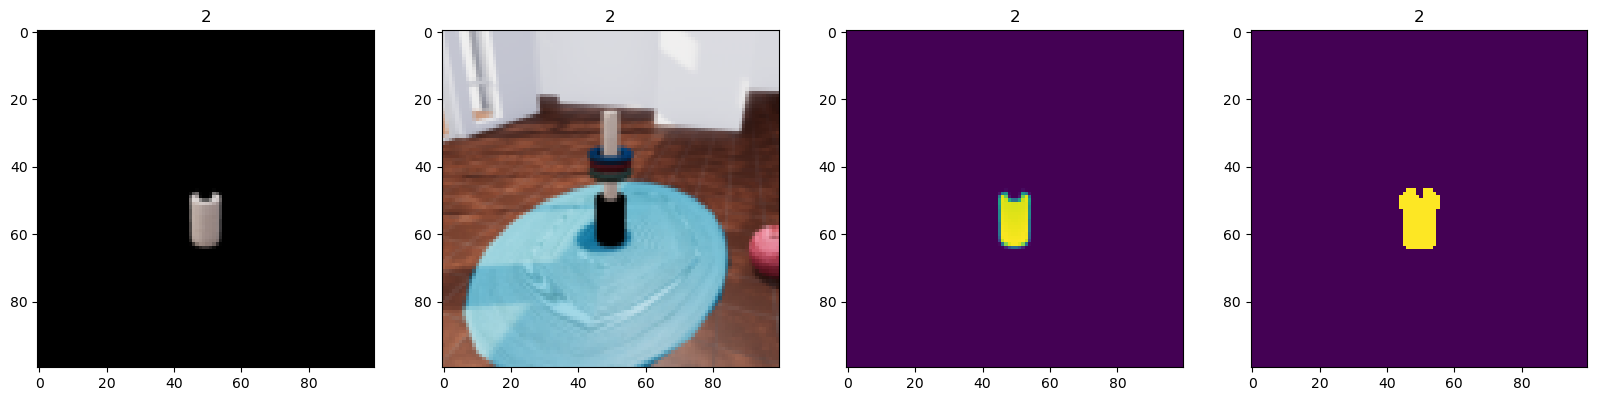

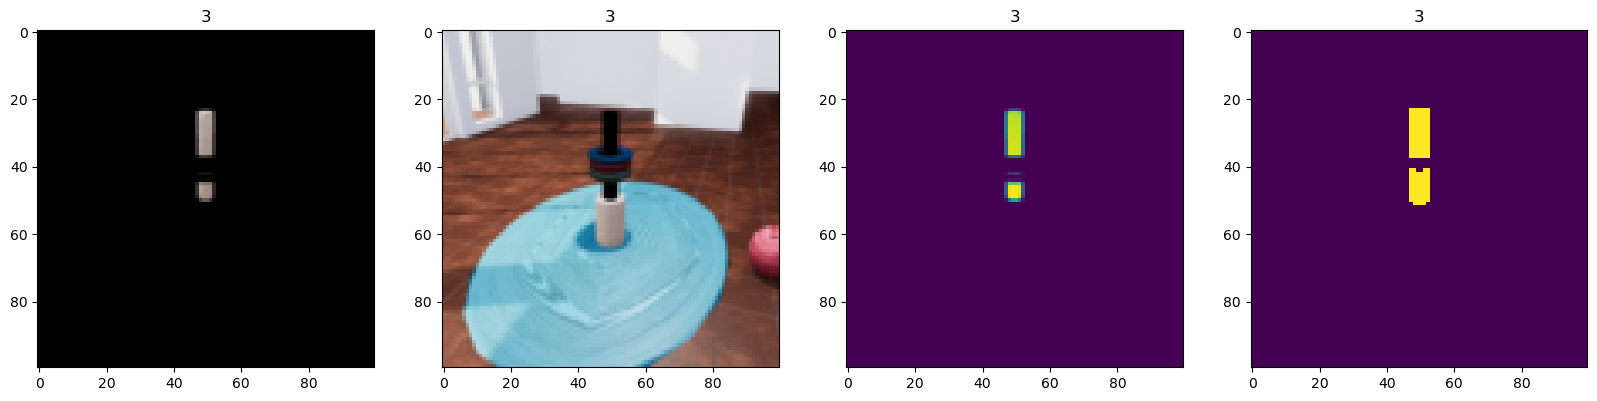

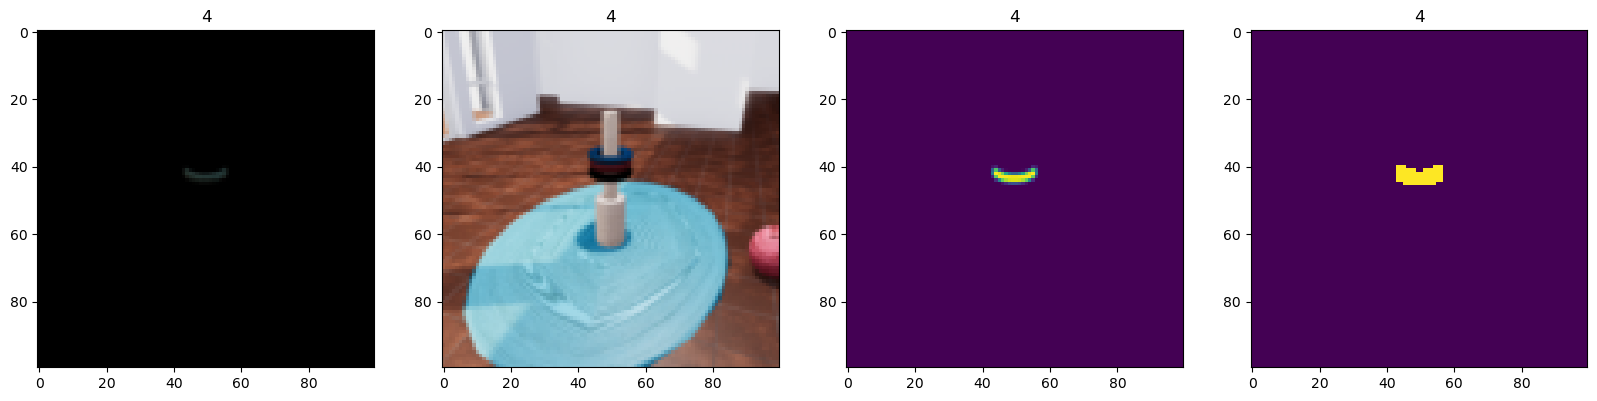

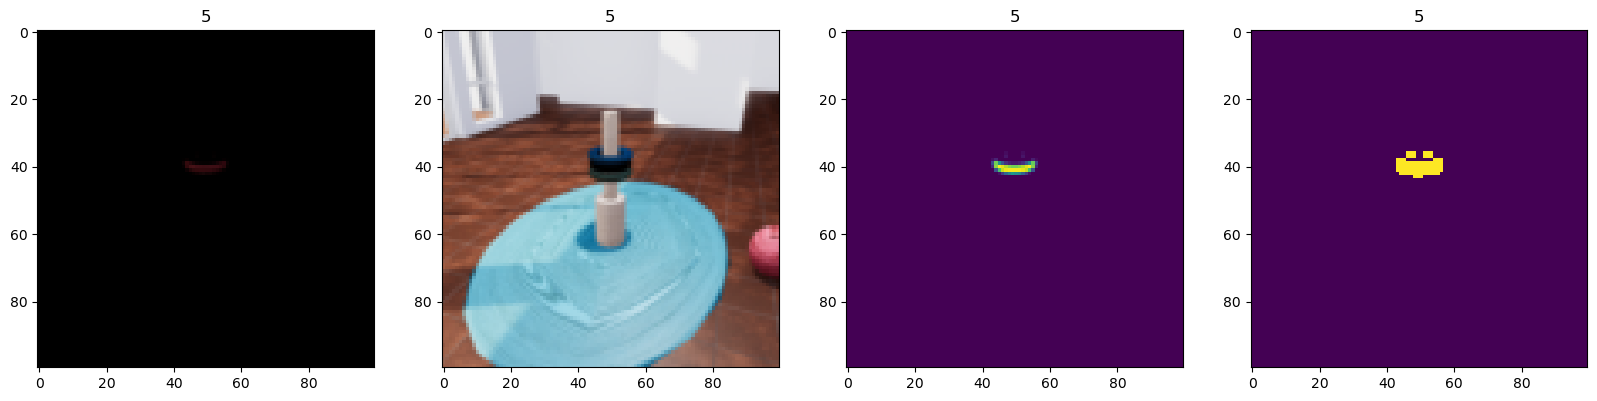

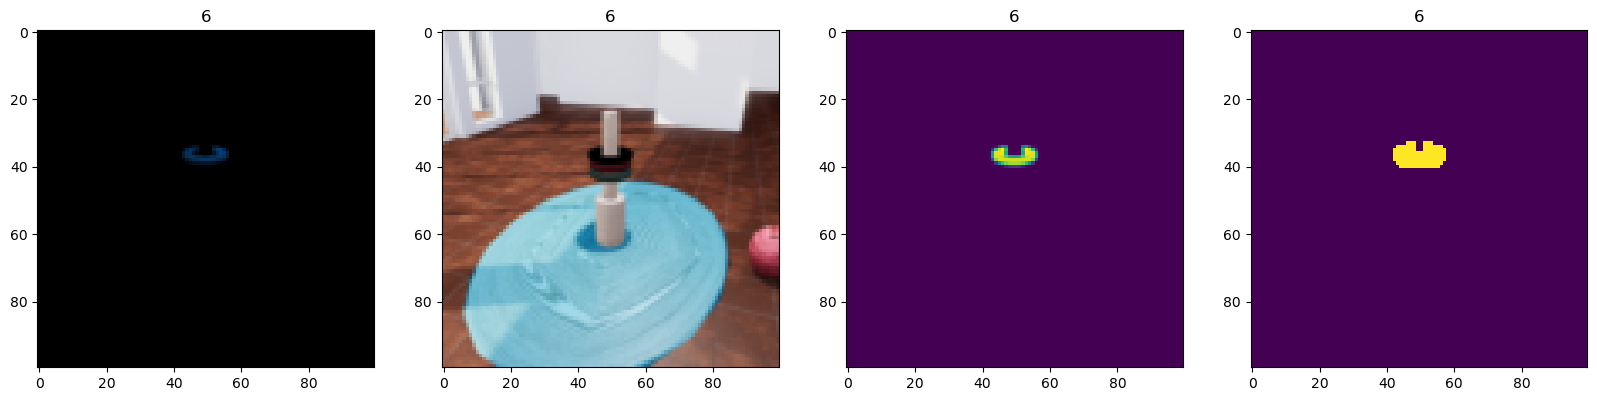

In [11]:
START_T = 0
# loop over all seg masks
for o_id, color in zip(object_ids, object_segmentation_colors):
    area = get_mask_area(im_seg, [color])
    image_masked = blackout_image(rgbds[START_T], area)
    depth_map_masked = image_masked[..., -1]
    rgb_masked = image_masked[..., 0:3]

    fig = plt.figure(figsize=[20, 5])
    ax = fig.add_subplot(141)
    ax.imshow(utils.resize_image_linear(rgb_masked, im_width, im_height))
    ax.set_title(f"{o_id}")

    ax = fig.add_subplot(143)
    ax.imshow(utils.resize_image_linear(depth_map_masked, im_width, im_height))
    ax.set_title(f"{o_id}")

    ax = fig.add_subplot(144)
    area = utils.resize_image_linear(depth_map_masked, im_width, im_height)> 0.0
    ax.imshow(area)
    ax.set_title(f"{o_id}")

    area = get_compli_mask_area(im_seg, [color])
    image_masked = blackout_image(rgbds[START_T], area)
    depth_map_masked = image_masked[..., -1]
    rgb_masked = image_masked[..., 0:3]

    ax = fig.add_subplot(142)
    ax.imshow(utils.resize_image_linear(rgb_masked, im_width, im_height))
    ax.set_title(f"{o_id}")

    # ax = fig.add_subplot(144)
    # area = utils.resize_image_linear(image_masked, im_width, im_height).sum(axis=2)> 0.0
    # ax.imshow(area)
    # ax.set_title(f"{o_id}")


In [12]:
utils.resize_image_linear(image_masked, im_width, im_height).sum(axis=2).shape

(100, 100)

In [ ]:
# object id inference
START_T = 0
num_inference_step = 5
best_index = {}
# loop over all seg masks
for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
    if o_id != 4:
        continue

    compli_area = get_compli_mask_area(im_seg, [color])
    compli_image_masked = blackout_image(rgbds[START_T], compli_area)

    compli_image_masked = utils.resize_image_linear(compli_image_masked, im_width, im_height)
    area = get_mask_area(im_seg, [color])
    image_masked = blackout_image(rgbds[START_T], area)
    compli_area = utils.resize_image_linear(image_masked, im_width, im_height)[..., 3] > 0.0
    compli_point_cloud = jnp.asarray(unproject_pixels(compli_area, compli_image_masked[..., -1], camera_matrix, renderer.fx, renderer.fy))
    
    # compli_point_cloud = jnp.asarray(unproject_pixels(compli_area, compli_image_masked[..., -1], camera_matrix, fx, fy))
    colors = jnp.array(compli_image_masked[..., 0:3][compli_area])
    vertices, faces, vertex_colors, _face_colors = (
        b3d.make_mesh_from_point_cloud_and_resolution(
            compli_point_cloud,
            colors,
            compli_point_cloud[:, 2]
            / renderer.fx
            * 2.0,  # This is scaling the size of the box to correspond to the effective size of the pixel in 3D. It really should be multiplied by 2.
            # and the 6 makes it larger
        )
    )
    background_mesh = b3d.Mesh(vertices, faces, vertex_colors)

    choice_map = dict([("camera_pose", camera_pose),
                          ("rgbd", utils.resize_image_linear(rgbds[START_T], im_width, im_height)),
                          ("depth_noise_variance", 0.01),
                          ("color_noise_variance", 1),
                          ("outlier_probability", 0.1),
                          ("object_pose_0", b3d.Pose.identity()),
                          ("object_scale_0", jnp.array([1.0,1.0,1.0])),])

    trace_compli, _ = importance_jit(
        jax.random.PRNGKey(0),
        genjax.ChoiceMap.d(
            choice_map
        ),
        (Pytree.const(("0",)), [background_mesh], likelihood_args),
    )
    viz_trace(trace_compli, 0, cloud=True)

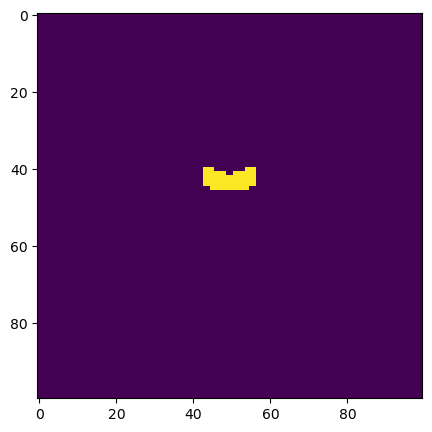

In [30]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax.imshow(compli_area)


In [ ]:
num_pose_grid = 11
position_search_thr = 0.2

# Gridding on translation only.
translation_deltas = b3d.Pose.concatenate_poses(
    [
        jax.vmap(lambda p: b3d.Pose.from_translation(p))(
            jnp.stack(
                jnp.meshgrid(
                    jnp.linspace(-position_search_thr, position_search_thr, num_pose_grid),
                    jnp.linspace(-position_search_thr, position_search_thr, num_pose_grid),
                    jnp.linspace(-position_search_thr, position_search_thr, num_pose_grid),
                ),
                axis=-1,
            ).reshape(-1, 3)
        ),
        b3d.Pose.identity()[None, ...],
    ]
)
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = b3d.Pose.concatenate_poses(
    [
        jax.vmap(b3d.Pose.sample_gaussian_vmf_pose, in_axes=(0, None, None, None))(
            jax.random.split(jax.random.PRNGKey(0), num_pose_grid * num_pose_grid * num_pose_grid),
            b3d.Pose.identity(),
            0.0001,
            100.0,
        ),
        b3d.Pose.identity()[None, ...],
    ]
)
all_deltas = b3d.Pose.stack_poses([translation_deltas, rotation_deltas])

# needs to be odd
num_scale_grid = 11
scale_search_thr = 0.3

scale_deltas = jnp.stack(
                jnp.meshgrid(
                    jnp.linspace(-scale_search_thr, scale_search_thr, num_scale_grid),
                    jnp.linspace(-scale_search_thr, scale_search_thr, num_scale_grid),
                    jnp.linspace(-scale_search_thr, scale_search_thr, num_scale_grid),
                ),
                axis=-1,
            ).reshape(-1, 3)

In [ ]:
# object id inference
START_T = 0
num_inference_step = 5
best_index = {}
# loop over all seg masks
for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
    if o_id != 4:
        continue
    this_best_index = {}
    print(f"patch {i}")
    area = get_mask_area(im_seg, [color])
    image_masked = blackout_image(rgbds[START_T], area)

    point_cloud = jnp.asarray(unproject_pixels(area, image_masked[..., -1], camera_matrix, fx, fy))
    point_cloud_centroid = point_cloud.mean(0)
    point_cloud_bottom = min(point_cloud[:,1])
    object_pose = b3d.Pose.from_translation(jnp.array([point_cloud_centroid[0], point_cloud_bottom, point_cloud_centroid[2]]))
    print("gt pose: ", object_pose)
    point_cloud_size = jnp.array((max(point_cloud[:,0])-min(point_cloud[:,0]), max(point_cloud[:,1])-min(point_cloud[:,1]), max(point_cloud[:,2])-min(point_cloud[:,2])))
    object_colors = jnp.asarray(image_masked[..., 0:3][area])
    mean_object_colors = np.mean(object_colors, axis=0)

    compli_area = get_compli_mask_area(im_seg, [color])
    compli_image_masked = blackout_image(rgbds[START_T], compli_area)
    compli_image_masked = utils.resize_image_linear(compli_image_masked, im_width, im_height)
    compli_area = compli_image_masked[..., 3] == 0.0
    compli_point_cloud = jnp.asarray(unproject_pixels(compli_area, compli_image_masked[..., -1], camera_matrix, fx, fy))
    colors = jnp.array(compli_image_masked[..., 0:3][compli_area])
    vertices, faces, vertex_colors, _face_colors = (
        b3d.make_mesh_from_point_cloud_and_resolution(
            compli_point_cloud,
            colors,
            compli_point_cloud[:, 2]
            / fx
            * 2.0,  # This is scaling the size of the box to correspond to the effective size of the pixel in 3D. It really should be multiplied by 2.
            # and the 6 makes it larger
        )
    )
    background_mesh = b3d.Mesh(vertices, faces, vertex_colors)

    choice_map = dict([("camera_pose", camera_pose),
                          ("rgbd", utils.resize_image_linear(rgbds[START_T], im_width, im_height)),
                          ("depth_noise_variance", 0.01),
                          ("color_noise_variance", 1),
                          ("outlier_probability", 0.1),
                          ("object_pose_0", b3d.Pose.identity()),
                          ("object_scale_0", jnp.array([1.0,1.0,1.0])),])

    trace_compli, _ = importance_jit(
        jax.random.PRNGKey(0),
        genjax.ChoiceMap.d(
            choice_map
        ),
        (Pytree.const(("0",)), [background_mesh], likelihood_args),
    )

    # loop over all possible meshes
    for j, (name, trim) in enumerate(ordered_all_meshes.items()):   
        # trim_copy = deepcopy(trim)
        print(f"{j} {name}")     
        bounding_box = trim.bounding_box
        bbox_corners = bounding_box.vertices
        original_size = jnp.array((max(bbox_corners[:,0])-min(bbox_corners[:,0]), max(bbox_corners[:,1])-min(bbox_corners[:,1]), max(bbox_corners[:,2])-min(bbox_corners[:,2])))
        object_scale = jnp.abs(point_cloud_size/original_size)
        # print("trim: ", trim.vertices)
        mesh = b3d.Mesh(scale_mesh(trim.vertices, object_scale), trim.faces, jnp.ones(trim.vertices.shape)*mean_object_colors)
        
        trace_post_initial_tracking = trace_compli

        new_choices = (
            genjax.ChoiceMap.d(
                {
                    "object_pose_1": object_pose,
                    "object_scale_1": jnp.array([1.0,1.0,1.0]),
                }
            )
            ^ trace_post_initial_tracking.get_choices()
        )

        trace, _ = importance_jit(
            jax.random.PRNGKey(0),
            new_choices,
            (Pytree.const([i for i in [0,1]]), [background_mesh, mesh], likelihood_args,),
        )

        
        # for seed in range(num_inference_step):
        #     key = jax.random.PRNGKey(seed)
        #     trace, key, _, _ = bayes3d.enumerate_and_select_best_move_pose(
        #         trace, Pytree.const((f"object_pose_1",)), key, all_deltas
        #     )
            # trace, key, posterior_scales, scores = bayes3d.enumerate_and_select_best_move_scale(
        #         trace, Pytree.const((f"object_scale_1",)), key, scale_deltas
        #     )
            
        # print(trace.get_score())
        # addr = f"object_pose_1"
        # current_pose = trace.get_choices()[addr]
        # print(f"pose: {current_pose}")
        # addr = f"object_scale_1"
        # current_scale = trace.get_choices()[addr]
        # print(f"scale: {current_scale}")
        # this_best_index[name] = [trace.get_score(), current_pose, b3d.Mesh(scale_mesh(mesh.vertices, current_scale), mesh.faces, jnp.ones(mesh.vertices.shape)*mean_object_colors), [(score.astype(float).item(), object_scale*posterior_scale) for (score, posterior_scale) in zip(scores, posterior_scales)]]

        viz_trace(trace, i*len(ordered_all_meshes)+j, cloud=True)
    best_index[o_id] = this_best_index

patch 4
gt pose:  Pose(position=Array([ 0.20417374,  1.7153261 , -0.5295556 ], dtype=float32), quaternion=Array([0., 0., 0., 1.], dtype=float32))
0 bowl
1 cone
2 cone_cyn_96_191
3 cone_cynlinder
4 cube
5 cylinder
6 cyn_96_96
7 cyn_96_96_96
8 octahedron
9 pentagon
10 pipe
11 platonic
12 pyramid
13 ramp_with_platform_30
14 sphere
15 torus
16 triangular_prism


In [ ]:
this_best_index

In [16]:
# if use_attachment and use_base and attachment_fixed:
#     base_info = best_index[np.where(object_ids == base_id)[0][0]]
#     best_base_name = max(base_info, key=lambda k: base_info[k][0])
#     best_base_info = base_info[best_base_name]

#     attachment_info = best_index[np.where(object_ids == attachment_id)[0][0]]
#     best_attachment_name = max(attachment_info, key=lambda k: attachment_info[k][0])
#     best_attachment_info = attachment_info[best_attachment_name]

#     print("best_base_name: ", np.where(object_ids == base_id)[0][0], best_base_name)
#     print("best_attachment_name: ", np.where(object_ids == attachment_id)[0][0], best_attachment_name)

#     joint_poses = [best_base_info[1], best_attachment_info[1]]
#     joint_meshes = [best_base_info[2], best_attachment_info[2]]
#     joint_mesh = b3d.Mesh.transform_and_merge_meshes(joint_meshes, joint_poses)
#     joint_mesh.rr_visualize("scene_mesh_in_camera_frame")

In [16]:
# prepare the json file to write
json_file = {}
num_sample = 20

In [ ]:
pose_mesh_from_point_cloud = {}
joint_poses = []
joint_meshes = []
json_file['model'] = {}
json_file['scale'] = {}
optim_scales = {}

for o_id, val in best_index.items():
    best_name = max(val, key=lambda k: val[k][0])
    json_file['model'][int(o_id)] = [best_name for _ in range(num_sample)]
    print(o_id, best_name)
    best_info = val[best_name]
    pose = best_info[1]
    mesh = best_info[2]
    scales = best_info[3]
    optim_scales[int(o_id)] = scales[0][1]
    json_file['scale'][int(o_id)] = [{"x": scale[0].astype(float).item(), "y": scale[1].astype(float).item(), "z": scale[2].astype(float).item()} for scale in sample_from_posterior(num_sample, scales)]
    if use_attachment and use_base and attachment_fixed and (o_id in [attachment_id, base_id]):
        if o_id == base_id:
            base_pose = pose
        elif o_id == attachment_id:
            attachment_pose = pose
            index_to_delete = np.where(object_ids == o_id)[0][0]
            object_ids = np.delete(object_ids, index_to_delete)
        joint_poses.append(pose)
        joint_meshes.append(mesh)
    else:
        pose_mesh_from_point_cloud[o_id] = [pose, mesh]
if joint_poses and joint_meshes:
    relative_pose = attachment_pose - base_pose
    pose_mesh_from_point_cloud[base_id] = [base_pose, b3d.Mesh.transform_and_merge_meshes(joint_meshes, joint_poses)]

0 cube
1 cube
2 cube


In [20]:
len(pose_mesh_from_point_cloud)

3

In [21]:
# try:
#     import cPickle as pickle
# except ImportError:  # Python 3.x
#     import pickle

# with open('/home/haoliangwang/b3d/best_index_domines.p', 'wb') as fp:
#     pickle.dump(best_index, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# with open('/home/hlwang_ipe_genjax/b3d/data13.p', 'rb') as fp:
#     best_index = pickle.load(fp)

In [23]:
# # skipping the object id inference step, directly assume that we know which segment corresponds to which mesh
# START_T = 0
# pose_mesh_color_from_point_cloud = []
# for (model_name, scale, color) in zip(model_names, scales, object_segmentation_colors):
#     area = get_mask_area(im_seg, color)
#     point_cloud = jnp.asarray(unproject_pixels(area, depth_arr[START_T], camera_matrix, fx, fy))
#     point_cloud_centroid = point_cloud.mean(0)
#     point_cloud_bottom = min(point_cloud[:,1])
#     object_pose = b3d.Pose.from_translation(np.array([point_cloud_centroid[0], point_cloud_bottom, point_cloud_centroid[2]]))
#     object_colors = jnp.asarray(image_arr[START_T][area])
#     mean_object_colors = np.mean(object_colors, axis=0)
#     trim = trimesh.load(os.path.join(mesh_file_path, f"{model_name.decode('UTF-8')}.obj"))
#     mesh = b3d.Mesh(scale_mesh(trim.vertices, scale), trim.faces, jnp.ones(trim.vertices.shape)*mean_object_colors)
#     pose_mesh_color_from_point_cloud.append((object_pose, mesh))

In [24]:
# %matplotlib widget

# for idx, (_, mesh) in enumerate(pose_mesh_color_from_point_cloud):
#       print(idx)
#       fig = plt.figure()
#       ax = fig.add_subplot(projection='3d')
#       ax.set_box_aspect([1,1,1])
#       ax.plot_trisurf(mesh[0][:, 0], mesh[0][:,2], mesh[0][:,1], triangles=mesh[1], color=np.mean(mesh[2], axis=0).tolist())
#       set_axes_equal(ax)

In [25]:
# %matplotlib widget

# START_T = 0
# # all_object_poses = []
# pose_color_from_point_cloud = []
# for color in counter:
#     if not np.array_equal(color,  np.array([0,0,0])):
#         area = get_mask_area(im_seg, color)
#         point_cloud = jnp.asarray(unproject_pixels(area, depth_arr[START_T], camera_matrix, fx, fy))
#         point_cloud_centroid = point_cloud.mean(0)
#         point_cloud_bottom = min(point_cloud[:,1])
#         object_pose = b3d.Pose.from_translation(np.array([point_cloud_centroid[0], point_cloud_bottom, point_cloud_centroid[2]]))
#         object_colors = jnp.asarray(image_arr[START_T][area])
#     pose_color_from_point_cloud.append((object_pose, object_colors))



#         # # Create new mesh.
#         img_seg_colors = jnp.asarray(image_arr[START_T][area])
#         # point_cloud_colors = jnp.full(image_arr[START_T][area].shape, 1)
#         # vertices, faces, vertex_colors, _face_colors = (
#         #     b3d.make_mesh_from_point_cloud_and_resolution(
#         #         point_cloud, point_cloud_colors, point_cloud[:, 2] / fx * 2.0
#         #     )
#         # )
#         # fig = plt.figure()
#         # ax = fig.add_subplot(projection='3d')
#         # ax.set_box_aspect([1,1,1])
#         # ax.plot_trisurf(vertices[:, 0], vertices[:,2], vertices[:,1], triangles=faces)
#         # set_axes_equal(ax)
#         # object_pose = b3d.Pose.from_translation(vertices.mean(0))
#         # all_object_poses.append(object_pose)

In [26]:
# all_object_poses_gt = []
# for idx in range(len(object_ids)):
#     object_pose = b3d.Pose(jnp.asarray(initial_position[idx]), jnp.asarray(euler_angles_to_quaternion(initial_rotation[idx])))
#     all_object_poses_gt.append(object_pose)
# all_object_poses_gt

In [27]:
# # Gridding on translation only.
# translation_deltas = b3d.Pose.concatenate_poses(
#     [
#         jax.vmap(lambda p: b3d.Pose.from_translation(p))(
#             jnp.stack(
#                 jnp.meshgrid(
#                     jnp.linspace(-0.2, 0.2, 11),
#                     jnp.linspace(-0.2, 0.2, 11),
#                     jnp.linspace(-0.2, 0.2, 11),
#                 ),
#                 axis=-1,
#             ).reshape(-1, 3)
#         ),
#         b3d.Pose.identity()[None, ...],
#     ]
# )
# # Sample orientations from a VMF to define a "grid" over orientations.
# rotation_deltas = b3d.Pose.concatenate_poses(
#     [
#         jax.vmap(b3d.Pose.sample_gaussian_vmf_pose, in_axes=(0, None, None, None))(
#             jax.random.split(jax.random.PRNGKey(0), 11 * 11 * 11),
#             b3d.Pose.identity(),
#             0.0001,
#             100.0,
#         ),
#         b3d.Pose.identity()[None, ...],
#     ]
# )
# all_deltas = b3d.Pose.stack_poses([translation_deltas, rotation_deltas])

In [29]:
# rgbds = jnp.concatenate([jnp.flip(image_arr,2), jnp.reshape(jnp.flip(depth_arr,2), depth_arr.shape+(1,))], axis=-1)
# rgbds.shape

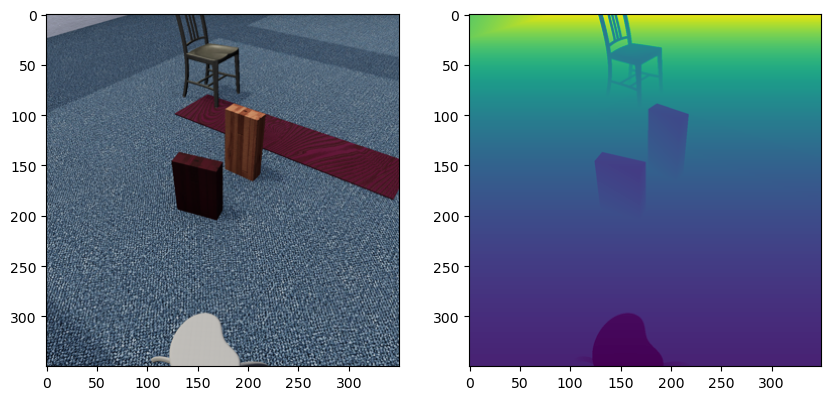

In [30]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(121)
ax.imshow(rgbds[START_T][..., 0:3])

ax = fig.add_subplot(122)
ax.imshow(rgbds[START_T][..., -1])

In [31]:
# Initial trace for timestep 0
choice_map = dict([("camera_pose", camera_pose), 
                   ("rgbd", rgbds[START_T]), 
                   ("depth_noise_variance", 0.01),
                   ("color_noise_variance", 1),
                   ("outlier_probability", 0.1)] + 
                   [(f"object_pose_{o_id}", pose_mesh_from_point_cloud[o_id][0]) for o_id in object_ids]
                   + [(f"object_scale_{o_id}", jnp.array([1.0,1.0,1.0])) for o_id in object_ids])

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.ChoiceMap.d(
        choice_map
    ),
    (
        {
            "object_ids": Pytree.const([o_id for o_id in object_ids]),
            "meshes": [pose_mesh_from_point_cloud[o_id][1] for o_id in object_ids],
            "likelihood_args": likelihood_args,
        },
    ),
)

viz_trace(trace, START_T)

In [32]:
# with open("/home/haoliangwang/b3d/trace_1st_frame_dominoes.pickle", "wb") as output_file:
#     msgpack_serialize.dump(trace, output_file)

In [33]:
# with open("/home/haoliangwang/b3d/trace_1st_frame_dominoes.pickle", "rb") as output_file:
#     retrieved_tr = msgpack_serialize.load(output_file, model, (Pytree.const(num_obj), [pose_mesh_from_point_cloud[idx][1] for idx in range(num_obj)], likelihood_args))
# bayes3d.rerun_visualize_trace_t(retrieved_tr, 0)

In [34]:
# def _enumerate_and_select_best_move_new(trace, addressses, key, all_deltas, k=20):
#     pose_addr = addressses.const[0]
#     current_pose = trace.get_choices()[pose_addr]
#     scale_addr = addressses.const[1]
#     current_scale = trace.get_choices()[scale_addr]
#     # jax.debug.print("init_poses: {v}", v=current_pose)
#     # jax.debug.print("init_scale: {v}", v=current_scale)
#     for i in range(len(all_deltas[0])):
#         test_poses = current_pose @ all_deltas[0][i]
#         test_scales = current_scale + (all_deltas[1] / (i + 1))
#         # jnp.multiply(current_scale, all_deltas[1])
#         # jax.debug.print("test_poses: {v}", v=test_poses)
#         # jax.debug.print("test_scales: {v}", v=test_scales)
#         all_scores = jnp.array([])
#         for test_scale in test_scales:
#             # test_scale = jnp.multiply(current_scale, scale)
#             # return test_scale
#             potential_scores = b3d.enumerate_choices_get_scores(
#                 trace, addressses, test_poses, test_scale
#             )
#             all_scores = jnp.hstack([all_scores, potential_scores])
#         # jax.debug.print("all_scores: {v}", v=all_scores)
#         optimal_idx = all_scores.argmax()
#         # jax.debug.print("optimal_idx: {v}", v=optimal_idx)
#         # jax.debug.print("optimal_idx pose: {v}", v=(optimal_idx % len(all_deltas[0][i])))
#         # jax.debug.print("optimal_idx scale: {v}", v=(optimal_idx // len(all_deltas[0][i])))
#         current_pose = test_poses[(optimal_idx % len(all_deltas[0][i]))]
#         current_scale = test_scales[optimal_idx // len(all_deltas[0][i])]
#         if i == len(all_deltas[0])-1:
#             top_k_indices = jnp.argsort(all_scores)[-k:][::-1]
#             posterior_pose = [test_poses[(optimal_idx % len(all_deltas[0][i]))] for optimal_idx in top_k_indices]
#             posterior_scale = [test_scales[optimal_idx // len(all_deltas[0][i])] for optimal_idx in top_k_indices]
#         # jax.debug.print("current_pose: {v}", v=current_pose)
#         # jax.debug.print("current_scale: {v}", v=current_scale)
#     trace = b3d.update_choices(trace, addressses, current_pose, current_scale)
#     return trace, key, posterior_pose, posterior_scale

# enumerate_and_select_best_move_new = jax.jit(
#     _enumerate_and_select_best_move_new, static_argnames=["addressses"]
# )

In [35]:
FINAL_T = 45
key = jax.random.PRNGKey(seed)
posterior_across_frames = {'pose':[]}
for T_observed_image in tqdm(range(FINAL_T)):
    posterior_across_frames['pose'].append({})
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices(
        trace,
        Pytree.const(("rgbd",)),
        rgbds[T_observed_image],
    )
 
    for o_id in object_ids:
        trace, key, posterior_poses, scores = bayes3d.enumerate_and_select_best_move_pose(
            trace, Pytree.const((f"object_pose_{o_id}",)), key, all_deltas
        )
        posterior_across_frames['pose'][-1][int(o_id)] = [(score, posterior_pose) for (posterior_pose, score) in zip(posterior_poses, scores)]

    viz_trace(trace, T_observed_image)

100%|██████████| 45/45 [00:34<00:00,  1.30it/s]


In [38]:
# def quaternion_to_euler_angles(quaternion: np.ndarray) -> np.ndarray:
#     """
#     Convert a quaternion to Euler angles.

#     Source: https://stackoverflow.com/a/12122899

#     :param quaternion: A quaternion as a nump array.

#     :return: The Euler angles representation of the quaternion.
#     """
#     print("quaternion: ", quaternion)
#     _POLE: float = 0.49995
#     x = quaternion[0]
#     y = quaternion[1]
#     z = quaternion[2]
#     w = quaternion[3]

#     sqx = x * x
#     sqy = y * y
#     sqz = z * z
#     sqw = w * w

#     unit = sqx + sqy + sqz + sqw
#     test = x * w - y * z

#     if test > _POLE * unit:
#         ex = np.pi / 2
#         ey = 2 * np.arctan2(y, x)
#         ez = 0
#     elif test < -_POLE * unit:
#         ex = -np.pi / 2
#         ey = -2 * np.arctan2(y, x)
#         ez = 0
#     else:
#         qx = w
#         qy = z
#         qz = x
#         qw = y
#         sqqz = qz * qz
#         ex = np.arcsin(2 * (qx * qz - qw * qy))
#         ey = np.arctan2(2 * qx * qw + 2 * qy * qz, 1 - 2 * (sqqz + qw * qw))
#         ez = np.arctan2(2 * qx * qy + 2 * qz * qw, 1 - 2 * (qy * qy + sqqz))
#     return np.degrees(np.array([ex, ey, ez])) % 360


def quaternion_to_euler_angles(quaternion):
    rot = Rotation.from_quat(quaternion)
    rot_euler = rot.as_euler('xyz', degrees=True)
    return rot_euler

def compute_velocity(key, name, scale, pose_samples_from_posterior_last_frame, pose_samples_from_posterior_window_frame, dt):
    def compute_center_of_mass(pose_samples_from_posterior):
        object_pose_idx = np.random.choice(len(pose_samples_from_posterior))
        object_pose = pose_samples_from_posterior[object_pose_idx]
        q = object_pose._quaternion
        print("q: ", q)
        bounding_box_transform = bounding_box_b3d.transform(object_pose)
        bounding_box_transform = trimesh.Trimesh(bounding_box_transform.vertices, bounding_box_transform.faces)
        center_of_mass = bounding_box_transform.center_mass
        return center_of_mass, q
    print("scale: ", scale)
    np.random.seed(key)
    trim = ordered_all_meshes[name]
    mesh_tri = trimesh.Trimesh(vertices=scale_mesh(trim.vertices, scale), faces=trim.faces)
    oriented_bbox = mesh_tri.bounding_box
    bounding_box_b3d = b3d.Mesh.from_trimesh(oriented_bbox)

    pos_now, q_now = compute_center_of_mass(pose_samples_from_posterior_last_frame)
    pos_last, q_last = compute_center_of_mass(pose_samples_from_posterior_window_frame)
    linear_vel = (pos_now-pos_last)/dt

    angular_velocity = (2 / dt) * np.array([
        q_last[0]*q_now[1] - q_last[1]*q_now[0] - q_last[2]*q_now[3] + q_last[3]*q_now[2],
        q_last[0]*q_now[2] + q_last[1]*q_now[3] - q_last[2]*q_now[0] - q_last[3]*q_now[1],
        q_last[0]*q_now[3] - q_last[1]*q_now[2] + q_last[2]*q_now[1] - q_last[3]*q_now[0]])
    ang_vel = np.dot(angular_velocity, np.array([[0,0,1],[0,-1,0],[-1,0,0]]))

    return {"x": linear_vel[0], "y": linear_vel[1], "z": linear_vel[2]}, {"x": ang_vel[0], "y": ang_vel[1], "z": ang_vel[2]}


In [39]:
# processs the posterior into a json file that tdw can read
fps = 100
smoothing_window_size = 3

def get_posterior_poses_for_frame(frame, num_sample, posterior_across_frames):
    pose_samples_from_posterior = {}
    for o_id, poses in posterior_across_frames['pose'][frame].items():
        pose_samples_from_posterior[o_id] = [pose for pose in sample_from_posterior(num_sample, poses)]
        if use_attachment and use_base and attachment_fixed and o_id == base_id:
            pose_samples_from_posterior[attachment_id] = [pose + relative_pose for pose in pose_samples_from_posterior[o_id]]
    return pose_samples_from_posterior

pose_samples_from_posterior_last_frame = get_posterior_poses_for_frame(-1, num_sample, posterior_across_frames)
pose_samples_from_posterior_window_frame = get_posterior_poses_for_frame(-(smoothing_window_size+1), num_sample, posterior_across_frames)
assert len(pose_samples_from_posterior_last_frame) == len(pose_samples_from_posterior_window_frame)

position_dict = dict(
    [(int(o_id), [{"x": pose._position[0].astype(float).item(), "y": pose._position[1].astype(float).item() if pose._position[1].astype(float).item()>=0 else 0, "z": pose._position[2].astype(float).item()} for pose in poses]) for o_id, poses in pose_samples_from_posterior_last_frame.items()]
)
rotation_dict = dict(
    [(int(o_id), [{"x": quaternion_to_euler_angles(pose._quaternion)[0].astype(float), "y": quaternion_to_euler_angles(pose._quaternion)[1].astype(float), "z": quaternion_to_euler_angles(pose._quaternion)[2].astype(float)} for pose in poses]) for o_id, poses in pose_samples_from_posterior_last_frame.items()]
)

velocity_dict = dict(
    [(int(o_id), [compute_velocity(key, json_file['model'][o_id][0], optim_scales[o_id], pose_samples_from_posterior_last_frame[o_id], pose_samples_from_posterior_window_frame[o_id], smoothing_window_size/fps) for key in range(num_sample)]) for o_id in pose_samples_from_posterior_last_frame.keys()]
)
linear_velocity_dict = dict(
    [(o_id, [value[i][0] for i in range(num_sample)]) for o_id, value in velocity_dict.items()]
)
angular_velocity_dict = dict(
    [(o_id, [value[i][1] for i in range(num_sample)]) for o_id, value in velocity_dict.items()]
)

json_file['position'] = position_dict
json_file['rotation'] = rotation_dict
json_file['velocity'] = linear_velocity_dict
json_file['angular_velocity'] = angular_velocity_dict

scale:  [0.43909526 0.00592251 2.3365421 ]
q:  [-0.01020944 -0.00492971 -0.01653415  0.9997991 ]
q:  [0. 0. 0. 1.]
scale:  [0.43909526 0.00592251 2.3365421 ]
q:  [0. 0. 0. 1.]
q:  [-0.0049566  -0.06217173  0.04695531  0.99694806]
scale:  [0.43909526 0.00592251 2.3365421 ]
q:  [4.2707329e-03 6.4573631e-02 8.1592408e-04 9.9790347e-01]
q:  [0. 0. 0. 1.]
scale:  [0.43909526 0.00592251 2.3365421 ]
q:  [0. 0. 0. 1.]
q:  [4.2707329e-03 6.4573631e-02 8.1592408e-04 9.9790347e-01]
scale:  [0.43909526 0.00592251 2.3365421 ]
q:  [0. 0. 0. 1.]
q:  [0. 0. 0. 1.]
scale:  [0.43909526 0.00592251 2.3365421 ]
q:  [4.2707329e-03 6.4573631e-02 8.1592408e-04 9.9790347e-01]
q:  [0. 0. 0. 1.]
scale:  [0.43909526 0.00592251 2.3365421 ]
q:  [0. 0. 0. 1.]
q:  [ 0.00637877 -0.0735793  -0.00870049  0.99723107]
scale:  [0.43909526 0.00592251 2.3365421 ]
q:  [0. 0. 0. 1.]
q:  [0. 0. 0. 1.]
scale:  [0.43909526 0.00592251 2.3365421 ]
q:  [4.2707329e-03 6.4573631e-02 8.1592408e-04 9.9790347e-01]
q:  [ 0.00151503 -0.098

In [40]:
json_file

{'model': {0: ['cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube'],
  1: ['cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube'],
  2: ['cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube',
   'cube']},
 'scale': {0: [{'x': 0.43909525871276855,
    'y': 0.004935425706207752,
    'z': 2.3365421295166016},
   {'x': 0.48788362741470337,
    'y': 0.0069095962680876255,
    'z': 2.725965738296509},
   {'x': 0.43909525871276855,
    'y': 0.0059225112199783325,
    'z': 2.725965738296509},
   {'x': 0.48788362741470337,
   

In [41]:
with h5py.File(hdf5_file_path, "r") as f:
    scales = np.array(f['static']['scale'])
    print("scales: ", scales[:3])
    for key in f['frames'].keys():
        frame_idx = int(key)
        if frame_idx != FINAL_T:
            continue
        positions = jnp.array(f['frames'][key]['objects']['positions_cam0'])
        rotations = jnp.array(f['frames'][key]['objects']['rotations_cam0'])
        velocities = jnp.array(f['frames'][key]['objects']['velocities'])
        angular_velocities = jnp.array(f['frames'][key]['objects']['angular_velocities'])
        print("positions: ", positions[:3])
        print("rotations: ", [quaternion_to_euler_angles(rot) for rot in rotations[:3]])
        print("velocities: ", velocities[:3])
        print("angular_velocities: ", angular_velocities[:3])


scales:  [[0.5        0.01       2.        ]
 [0.1        0.5        0.25      ]
 [0.1        0.39284536 0.2821491 ]]
positions:  [[ 8.5000002e-01  0.0000000e+00  0.0000000e+00]
 [ 2.6217070e-01  3.8459897e-04  3.2820890e-03]
 [-2.0507470e-01  5.4155834e-02 -1.4378030e-02]]
rotations:  [array([-0.,  0.,  0.]), array([-0.03557193,  4.774589  , -0.58439921]), array([-1.59448422e+01,  6.14477709e-02, -8.26019718e+01])]
velocities:  [[ 0.          0.          0.        ]
 [ 0.28932908  0.01912832  0.04389565]
 [ 0.2608792  -0.54820293 -0.14871147]]
angular_velocities:  [[ 0.          0.          0.        ]
 [-0.0428705   1.4173913  -0.41868222]
 [-1.9713737  -0.0355464  -3.3108544 ]]


In [230]:
with open('/home/haoliangwang/private-physics-bench/stimuli/stimuli/generation/placement/dominoes_0003.json', 'w') as f:
    json.dump(json_file, f)